In [122]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns


import tensorflow as tf
import math

# specify model
## prior: $\theta \sim Unif[-10,10]$
## simulator: $x|\theta \sim 0.5N(\theta, 1) + 0.5N(\theta, 0.01)$

In [144]:
NSAMPLE = 1000
p = 0.5

theta_data = np.float32(np.random.uniform(-10.0, 10.0, (1, NSAMPLE))).T

comp1 = np.array([norm.rvs(loc=theta_data[i], scale=1) for i in range(NSAMPLE)])
comp2 = np.array([norm.rvs(loc=theta_data[i], scale=0.1) for i in range(NSAMPLE)])
ind1 = np.random.binomial(n=1, p=p, size=NSAMPLE)
x_data = np.float32(ind1*comp1 + (1-ind1)*comp2)

# for simplicity when translating to TF, call theta "y"
y_data = theta_data

# for TF compatibility
x_data = x_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)

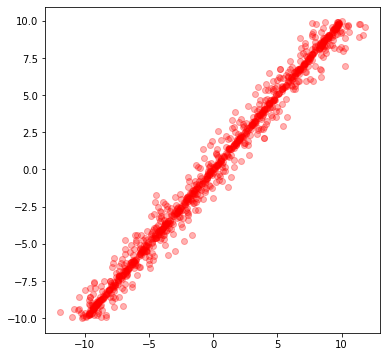

In [142]:
plt.figure(figsize=(6, 6))
plot_out = plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.show()

# fit MDNs using TensorFlow

In [132]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 2 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    
    out_pi, out_sigma, out_mu = tf.split(output, num_or_size_splits=3, axis=1) #tf.split(1, 3, output)

    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    #out_pi = tf.sub(out_pi, max_pi)
    out_pi = tf.subtract(out_pi, max_pi)

    out_pi = tf.exp(out_pi)

    #normalize_pi = tf.inv(tf.reduce_sum(out_pi, 1, keep_dims=True))
    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    #out_pi = tf.mul(normalize_pi, out_pi)
    out_pi = tf.multiply(normalize_pi, out_pi)

    out_sigma = tf.exp(out_sigma)

    return out_pi, out_sigma, out_mu

out_pi, out_sigma, out_mu = get_mixture_coef(output)

In [133]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
    #result = tf.sub(y, mu)
    result = tf.subtract(y, mu)
    #result = tf.mul(result,tf.inv(sigma))
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    #return tf.mul(tf.exp(result),tf.inv(sigma))*oneDivSqrtTwoPI
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    #result = tf.mul(result, out_pi)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

In [146]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    print(i)
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149


3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792


5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521


7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309


8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082


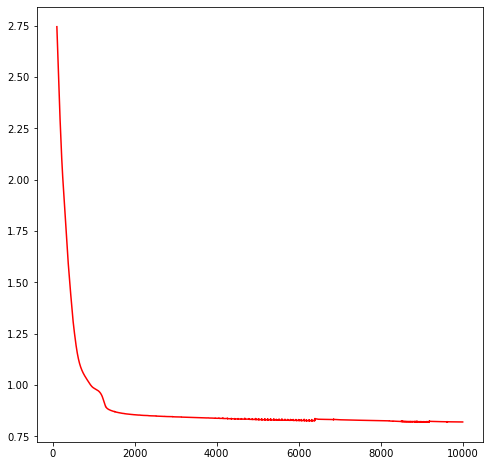

In [147]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [164]:
x_grid = np.float32(np.arange(-15,15,0.1))
NTEST = x_grid.size
x_grid = x_grid.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_grid.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

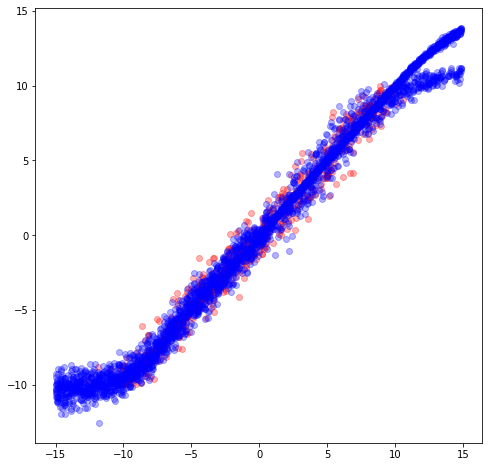

In [165]:
out_pi_grid, out_sigma_grid, out_mu_grid = sess.run(get_mixture_coef(output), feed_dict={x: x_grid})

y_grid = generate_ensemble(out_pi_grid, out_mu_grid, out_sigma_grid)

plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'ro', x_grid, y_grid, 'bo', alpha=0.3)
plt.show()

In [166]:
out_pi_grid

array([[9.9998415e-01, 1.5825093e-05],
       [9.9998415e-01, 1.5827191e-05],
       [9.9998415e-01, 1.5829561e-05],
       [9.9998415e-01, 1.5832187e-05],
       [9.9998415e-01, 1.5835103e-05],
       [9.9998415e-01, 1.5838288e-05],
       [9.9998415e-01, 1.5841793e-05],
       [9.9998415e-01, 1.5845617e-05],
       [9.9998415e-01, 1.5849773e-05],
       [9.9998415e-01, 1.5854279e-05],
       [9.9998415e-01, 1.5859132e-05],
       [9.9998415e-01, 1.5864382e-05],
       [9.9998415e-01, 1.5870011e-05],
       [9.9998415e-01, 1.5876096e-05],
       [9.9998415e-01, 1.5882639e-05],
       [9.9998415e-01, 1.5889605e-05],
       [9.9998415e-01, 1.5897123e-05],
       [9.9998415e-01, 1.5905131e-05],
       [9.9998415e-01, 1.5913718e-05],
       [9.9998403e-01, 1.5922886e-05],
       [9.9998403e-01, 1.5932699e-05],
       [9.9998403e-01, 1.5943187e-05],
       [9.9998403e-01, 1.5954351e-05],
       [9.9998403e-01, 1.5966314e-05],
       [9.9998403e-01, 1.5979080e-05],
       [9.9998403e-01, 1.

In [167]:
out_mu_grid

array([[-1.02797880e+01, -1.59711475e+01],
       [-1.02761002e+01, -1.59642086e+01],
       [-1.02722387e+01, -1.59571095e+01],
       [-1.02681952e+01, -1.59498463e+01],
       [-1.02639580e+01, -1.59424114e+01],
       [-1.02595177e+01, -1.59348011e+01],
       [-1.02548618e+01, -1.59270115e+01],
       [-1.02499790e+01, -1.59190369e+01],
       [-1.02448540e+01, -1.59108677e+01],
       [-1.02394772e+01, -1.59025002e+01],
       [-1.02338324e+01, -1.58939304e+01],
       [-1.02279034e+01, -1.58851452e+01],
       [-1.02216768e+01, -1.58761463e+01],
       [-1.02151337e+01, -1.58669205e+01],
       [-1.02082567e+01, -1.58574600e+01],
       [-1.02010279e+01, -1.58477573e+01],
       [-1.01934280e+01, -1.58378086e+01],
       [-1.01854353e+01, -1.58276043e+01],
       [-1.01770258e+01, -1.58171272e+01],
       [-1.01681786e+01, -1.58063793e+01],
       [-1.01588688e+01, -1.57953472e+01],
       [-1.01490698e+01, -1.57840195e+01],
       [-1.01387539e+01, -1.57723866e+01],
       [-1.

In [168]:
out_sigma_grid

array([[6.82048917e-01, 7.82102067e-03],
       [6.78867579e-01, 7.81406462e-03],
       [6.75703168e-01, 7.80670159e-03],
       [6.72556281e-01, 7.79890688e-03],
       [6.69427633e-01, 7.79065536e-03],
       [6.66318238e-01, 7.78191956e-03],
       [6.63228631e-01, 7.77266687e-03],
       [6.60159647e-01, 7.76286982e-03],
       [6.57112658e-01, 7.75250094e-03],
       [6.54087901e-01, 7.74151133e-03],
       [6.51086926e-01, 7.72988098e-03],
       [6.48110449e-01, 7.71756843e-03],
       [6.45160198e-01, 7.70454155e-03],
       [6.42236471e-01, 7.69075099e-03],
       [6.39340758e-01, 7.67617300e-03],
       [6.36474729e-01, 7.66074937e-03],
       [6.33638620e-01, 7.64443818e-03],
       [6.30834579e-01, 7.62719428e-03],
       [6.28063858e-01, 7.60897342e-03],
       [6.25327647e-01, 7.58972438e-03],
       [6.22627616e-01, 7.56939454e-03],
       [6.19965315e-01, 7.54793501e-03],
       [6.17342710e-01, 7.52528338e-03],
       [6.14760995e-01, 7.50139076e-03],
       [6.122220

# compute KL loss

In [172]:
# obs samples (theta,x) from joint distribution --> theta as obs sample from posterior given x
# negative log likelihood (based on out pi, mu, sigma) of observed theta according to f(theta|x), averaged across samples
out_pi_data, out_sigma_data, out_mu_data = sess.run(get_mixture_coef(output), feed_dict={x: x_data})

In [185]:
def compute_neg_log_lik(x, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=x, loc=mus[j], scale=sigmas[j])
    return -np.log(density)

In [186]:
all_neg_log_lik = [compute_neg_log_lik(x_data[i], out_pi_data[i], out_sigma_data[i], out_mu_data[i]) for i in range(NSAMPLE)]

In [188]:
x_data[3]

array([6.680055], dtype=float32)

In [189]:
out_pi_data[3]

array([0.54100627, 0.45899382], dtype=float32)

In [190]:
out_sigma_data[3]

array([0.97376597, 0.08840662], dtype=float32)

In [198]:
out_mu_data[3]

array([6.871056 , 6.6947503], dtype=float32)

In [199]:
norm.pdf(x=x_data[3], loc=out_mu_data[3][0], scale=out_sigma_data[3][0])

array([0.40188431])

In [200]:
norm.pdf(x=x_data[3], loc=out_mu_data[3][1], scale=out_sigma_data[3][1])

array([4.45067117])

In [187]:
all_neg_log_lik

[array([0.59255652]),
 array([0.43946004]),
 array([-0.7999824]),
 array([-0.81547654]),
 array([0.47101509]),
 array([0.53937006]),
 array([0.40017576]),
 array([0.43333268]),
 array([0.61284046]),
 array([-0.83390252]),
 array([-0.87872613]),
 array([0.67062942]),
 array([0.36413243]),
 array([-0.85953594]),
 array([-0.91479898]),
 array([-0.8768037]),
 array([0.43476758]),
 array([0.3641536]),
 array([0.54943615]),
 array([-0.84753412]),
 array([-0.85899843]),
 array([-0.82420866]),
 array([0.57095852]),
 array([0.55828496]),
 array([0.50878556]),
 array([0.44376886]),
 array([0.39426314]),
 array([0.50466559]),
 array([0.62335531]),
 array([0.488086]),
 array([0.55901351]),
 array([0.62861714]),
 array([0.51843565]),
 array([0.6182654]),
 array([-0.83730712]),
 array([-0.80055324]),
 array([-0.83440965]),
 array([-0.80382414]),
 array([-0.84720556]),
 array([0.66948403]),
 array([0.5081833]),
 array([-0.82813681]),
 array([0.53136104]),
 array([0.56216835]),
 array([0.60940677]),
 

In [203]:
# this is the KL loss for this model on obs data (up to additive constant)
1/NSAMPLE * sum(all_neg_log_lik)[0]

-0.12528666545007724

# compute PIT values

In [ ]:
# for each x across an x grid, calc pdf value (based on out pi, mu, sigma) of theta across a theta grid
theta_grid = np.linspace(-10, 10, 101)
cde_test

In [ ]:
print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=theta_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

In [ ]:
# obs samples (theta,x) from joint distribution --> theta as obs posterior sample given x
theta_test

In [ ]:
pit_values = cdf_coverage(cde_test, theta_grid, theta_test)

In [5]:
cutoff_idx = 60000
x_train = np.array([[x1,x2] for x1,x2 in zip(x1_vals[:cutoff_idx], x2_vals[:cutoff_idx])])
x_test = np.array([[x1,x2] for x1,x2 in zip(x1_vals[cutoff_idx:], x2_vals[cutoff_idx:])])
z_train = np.array(y_vals[:cutoff_idx])
z_test = np.array(y_vals[cutoff_idx:])

In [6]:
k = 50
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=x_train, z_train=z_train)

# for confidence sets

In [623]:
def get_confidence_band_range(n_trials=100, name='x1x2', alpha=0.05, points=[[1,2]]):
    sample = [1 - all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\alpha$, coverage heatmap

In [26]:
alpha = 0.2

In [27]:
x_range = np.linspace(-5,5,51)
x1, x2 = np.meshgrid(x_range, x_range)
grid = np.hstack([x1.ravel().reshape(-1,1), x2.ravel().reshape(-1,1)])
x_range_round = [round(x,1) for x in x_range]

In [32]:
ind_pit_values = [1*(x<=alpha) for x in pit_values]
ind_pit_values_x1 = [1*(x<=alpha) for x in pit_values_x1]
ind_pit_values_x2 = [1*(x<=alpha) for x in pit_values_x2]
ind_pit_values_marg = [1*(x<=alpha) for x in pit_values_marg]

In [33]:
rhat_alpha = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha.fit(X=x_test, y=ind_pit_values)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [34]:
rhat_alpha_x1 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x1.fit(X=x_test, y=ind_pit_values_x1)

rhat_alpha_x2 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x2.fit(X=x_test, y=ind_pit_values_x2)

rhat_alpha_marg = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_marg.fit(X=x_test, y=ind_pit_values_marg)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
alpha_pred = rhat_alpha.predict_proba(grid)[:, 1]
alpha_pred_x1 = rhat_alpha_x1.predict_proba(grid)[:, 1]
alpha_pred_x2 = rhat_alpha_x2.predict_proba(grid)[:, 1]
alpha_pred_marg = rhat_alpha_marg.predict_proba(grid)[:, 1]

In [548]:
"""
X_test_logit = sm.add_constant(x_test)
grid_logit = sm.add_constant(grid)

rhat_logit = sm.Logit(endog=ind_pit_values, exog=X_test_logit).fit(disp=0)
rhat_logit_x1 = sm.Logit(endog=ind_pit_values_x1, exog=X_test_logit).fit(disp=0)
rhat_logit_x2 = sm.Logit(endog=ind_pit_values_x2, exog=X_test_logit).fit(disp=0)
rhat_logit_marg = sm.Logit(endog=ind_pit_values_marg, exog=X_test_logit).fit(disp=0)
"""

In [554]:
"""
alpha_logit_pred = rhat_logit.predict(grid_logit)
alpha_logit_pred_x1 = rhat_logit_x1.predict(grid_logit)
alpha_logit_pred_x2 = rhat_logit_x2.predict(grid_logit)
alpha_logit_pred_marg = rhat_logit_marg.predict(grid_logit)
"""

In [633]:
confidence_fixedalpha = {}
confidence_fixedalpha['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])
confidence_fixedalpha['x1'] = np.array([get_confidence_band_range(name='x1', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['x2'] = np.array([get_confidence_band_range(name='x2', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['marg'] = np.array([get_confidence_band_range(name='marg', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])

In [665]:
fixedalpha_within_null = {}
fixedalpha_within_null['x1x2'] = np.array([1 * (1 - alpha_pred[i] < confidence_fixedalpha['x1x2'][i][0]
          or 1 - alpha_pred[i] > confidence_fixedalpha['x1x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x1'] = np.array([1 * (1 - alpha_pred_x1[i] < confidence_fixedalpha['x1'][i][0]
          or 1 - alpha_pred_x1[i] > confidence_fixedalpha['x1'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x2'] = np.array([1 * (1 - alpha_pred_x2[i] < confidence_fixedalpha['x2'][i][0]
          or 1 - alpha_pred_x2[i] > confidence_fixedalpha['x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['marg'] = np.array([1 * (1 - alpha_pred_marg[i] < confidence_fixedalpha['marg'][i][0]
          or 1 - alpha_pred_marg[i] > confidence_fixedalpha['marg'][i][1]) for i in range(len(alpha_pred))])

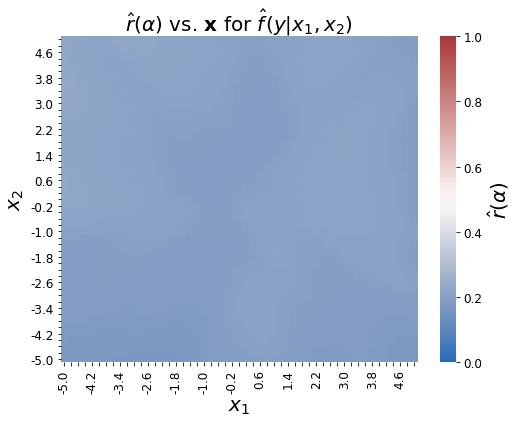

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

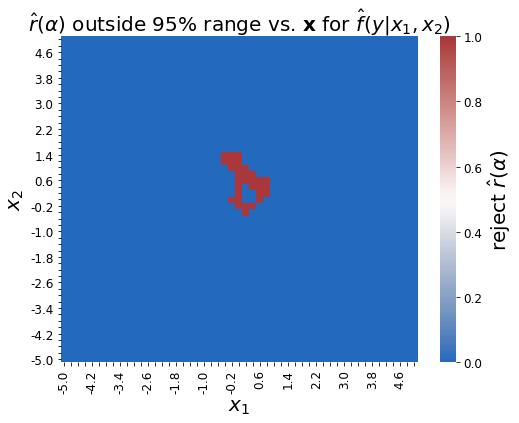

In [659]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

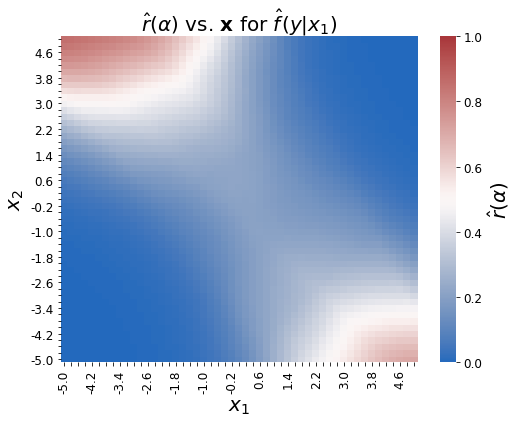

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x1.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

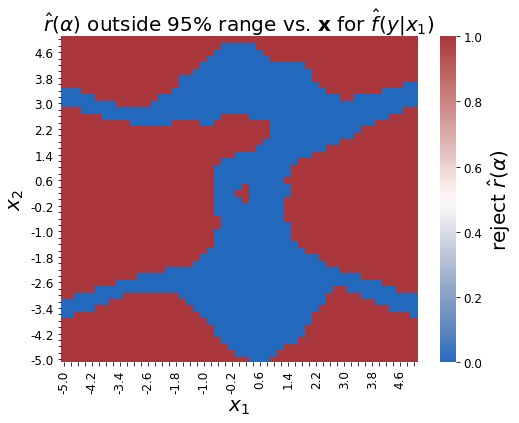

In [666]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

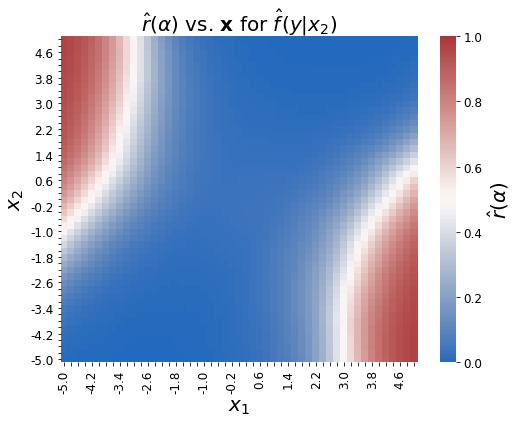

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x2.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

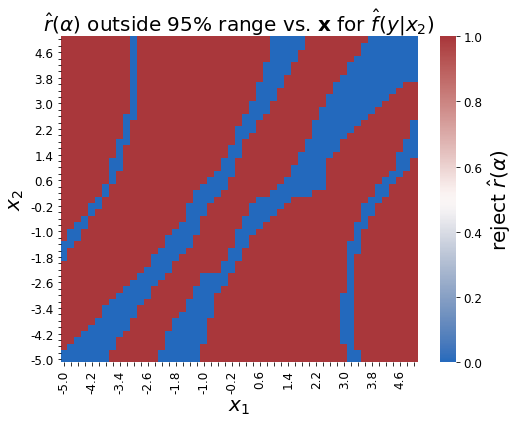

In [667]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

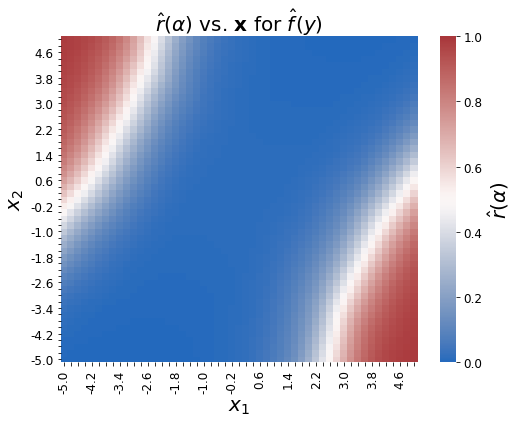

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_marg.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

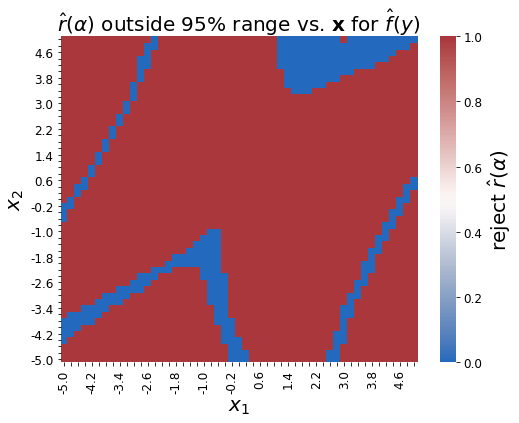

In [669]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['marg'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $1-\alpha$

In [40]:
x1 = 4
x2 = -4
points = np.array([[x1,x2]])
points_logit = np.array([[1,x1,x2]])

In [65]:
alphas = np.linspace(0.01, 0.99, 99)
pit_values_dict = {'x1x2': pit_values, 'x1': pit_values_x1, 'x2': pit_values_x2, 'marg': pit_values_marg}

In [66]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1][0]
rhat_alphas_xi = pd.DataFrame(rhat_alphas_xi)

working on classifier x1x2
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier x1
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999

In [542]:
"""
############# FOR CONFIDENCE INTERVALS #############

rhat_logit_alphas_xi = {}
rhat_logit_alphas_xi_se = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_logit_alphas_xi[name] = {}
    rhat_logit_alphas_xi_se[name] = {}
    
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat_logit = sm.Logit(endog=ind_values, exog=X_test_logit).fit(disp=0)
        pred = rhat_logit.predict(points_logit)[0]
        rhat_logit_alphas_xi[name][alpha] = pred
        
        # standard error
        rhat_logit_alphas_xi_se[name][alpha] = np.sqrt(np.array([xx@rhat_logit.cov_params()@xx for xx in points_logit]))[0]
        
rhat_logit_alphas_xi = pd.DataFrame(rhat_logit_alphas_xi)
rhat_logit_alphas_xi_se = pd.DataFrame(rhat_logit_alphas_xi_se)
"""

working on classifier x1x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x1
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier marg
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95


In [616]:
confidence_qqplot = {}
confidence_qqplot['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['x1'] = np.array([get_confidence_band_range(name='x1', alpha=i, points=points) for i in alphas])
confidence_qqplot['x2'] = np.array([get_confidence_band_range(name='x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['marg'] = np.array([get_confidence_band_range(name='marg', alpha=i, points=points) for i in alphas])

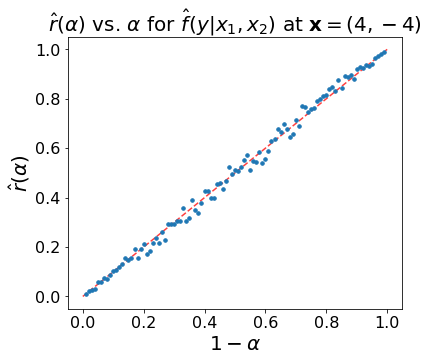

In [67]:
rhat_alphas_xi['x1x2'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x1x2'].index,
                 confidence_qqplot['x1x2'][:, 0],
                 confidence_qqplot['x1x2'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1,x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

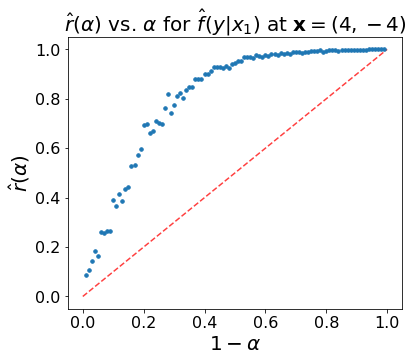

In [68]:
rhat_alphas_xi['x1'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x1'].index,
                 confidence_qqplot['x1'][:, 0],
                 confidence_qqplot['x1'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

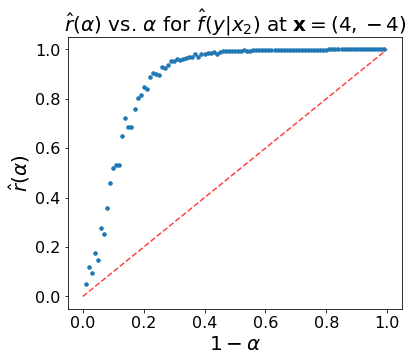

In [69]:
rhat_alphas_xi['x2'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['x2'].index,
                 confidence_qqplot['x2'][:, 0],
                 confidence_qqplot['x2'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

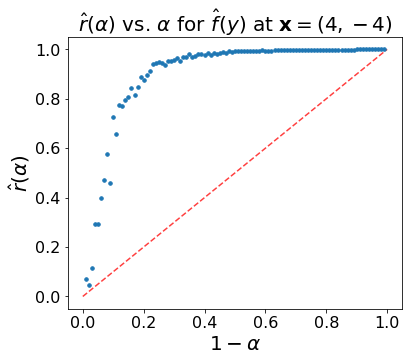

In [70]:
rhat_alphas_xi['marg'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['marg'].index,
                 confidence_qqplot['marg'][:, 0],
                 confidence_qqplot['marg'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [76]:
#with open('rhat_alphas_xi_20210127.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [71]:
Ti_values = {}
all_rhat_alphas = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    all_rhat_alphas[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        
        # fit rhat at each point in prediction grid
        all_rhat_alphas[name][alpha] = rhat.predict_proba(grid)[:, 1]
        
    # rhat_alphas for all alphas at all points
    all_rhat_alphas[name] = pd.DataFrame(all_rhat_alphas[name])
    
    # compute Ti summary statistic
    Ti_values[name] = ((all_rhat_alphas[name] - alphas)**2).sum(axis=1) / len(alphas)

working on classifier x1x2
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier x1
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999

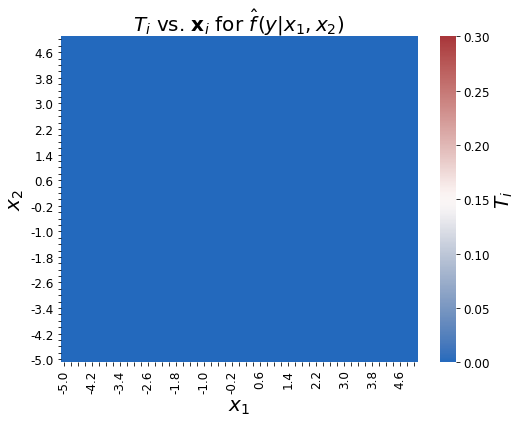

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

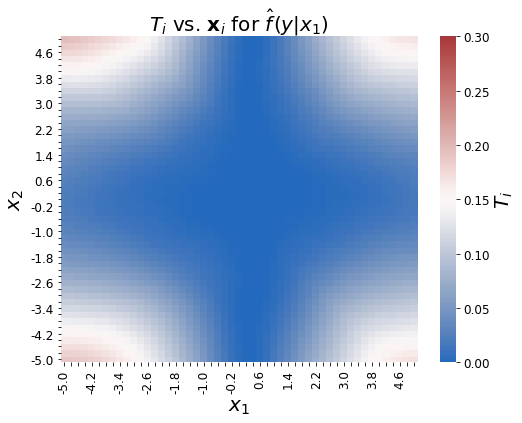

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

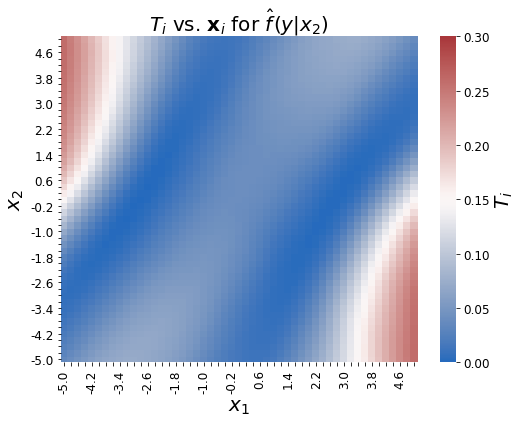

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

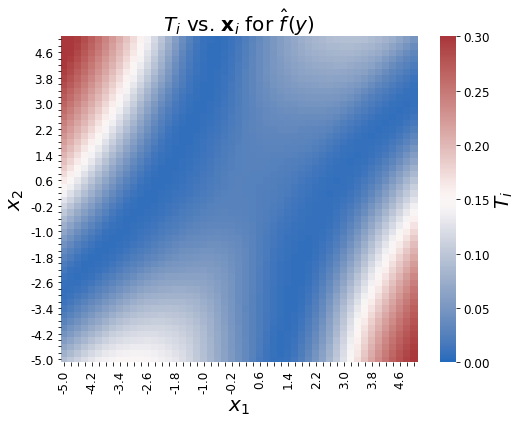

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [78]:
#with open('Ti_values_20210127.pkl', 'wb') as handle:
#    pickle.dump(Ti_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

# global p-value based on $T_i$

In [462]:
global_pvalues = sum([1* (pd.DataFrame(true_Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

x1x2    0.09
x1      0.00
x2      0.00
marg    0.00
dtype: float64

# local p-values based on $T_i$: local CvM test

In [63]:
#with open('pit_values_dict.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
#np.save('x_test.npy', x_test)

### saved $\hat r$ from MC samples, to build CIs

In [564]:
with open("all_rhat_classifiers_.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [568]:
all_rhat_classifiers[0]['x1x2']

{0.05: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm

In [573]:
all_rhat_classifiers[0]['x1x2'][0.05].predict_proba([[1,2]])

array([[0.04379426, 0.95620574]])

In [328]:
with open("Ti_values.pkl", 'rb') as handle:
    true_Ti_values = pickle.load(handle)
with open("all_unif_Ti_values.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [352]:
all_pvalues = sum([1* (pd.DataFrame(true_Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,x1x2,x1,x2,marg
0,0.20,0.0,0.00,0.0
1,0.21,0.0,0.00,0.0
2,0.19,0.0,0.00,0.0
3,0.20,0.0,0.01,0.0
4,0.24,0.0,0.02,0.0
...,...,...,...,...
2596,0.14,0.0,0.08,0.0
2597,0.16,0.0,0.02,0.0
2598,0.18,0.0,0.00,0.0
2599,0.20,0.0,0.00,0.0


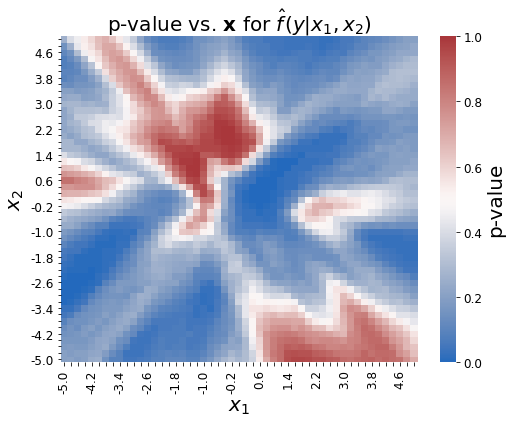

In [362]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

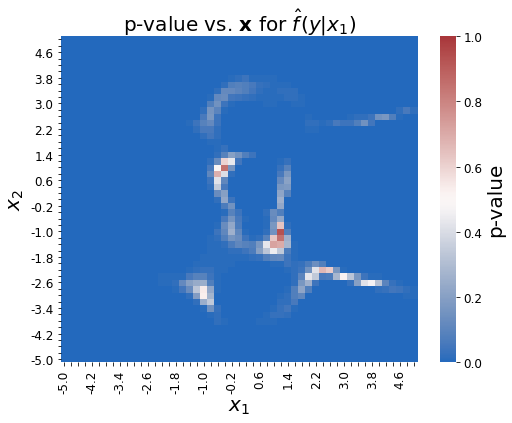

In [363]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

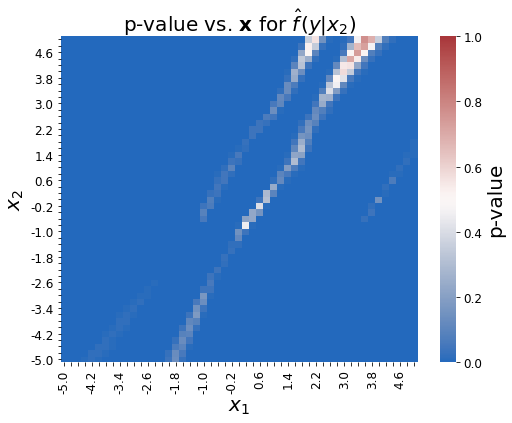

In [364]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

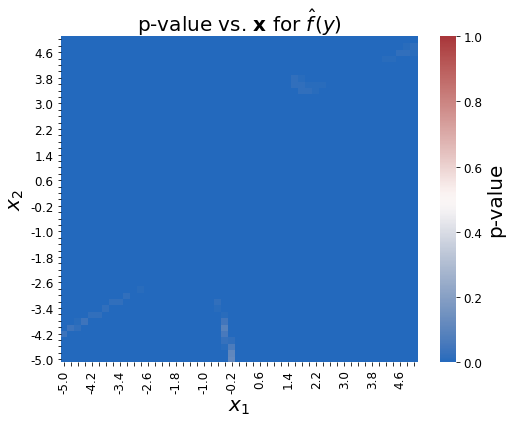

In [365]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Benjamini-Hochberg FDR correction

In [368]:
m = 51*51
alpha = 0.05

In [392]:
bh_values = alpha * (np.arange(m) + 1) / m

In [431]:
f_type = 'x1x2'
pval_vs_bh = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh.index
pval_vs_bh_sorted = pd.Series(pval_vs_bh.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_sorted == 1].index[-1]
bh_rejections = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                          index=use_idx)

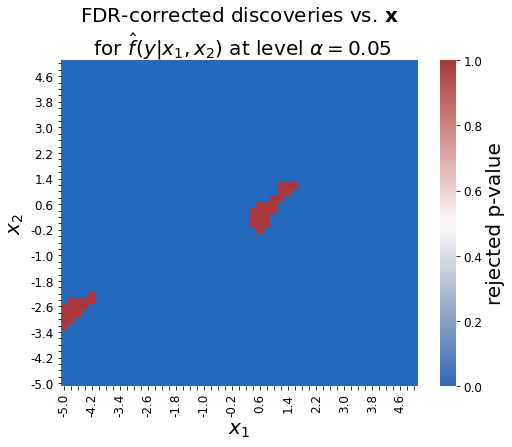

In [442]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1,x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [443]:
f_type = 'x1'
pval_vs_bh_x1 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x1.index
pval_vs_bh_x1_sorted = pd.Series(pval_vs_bh_x1.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x1_sorted == 1].index[-1]
bh_rejections_x1 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

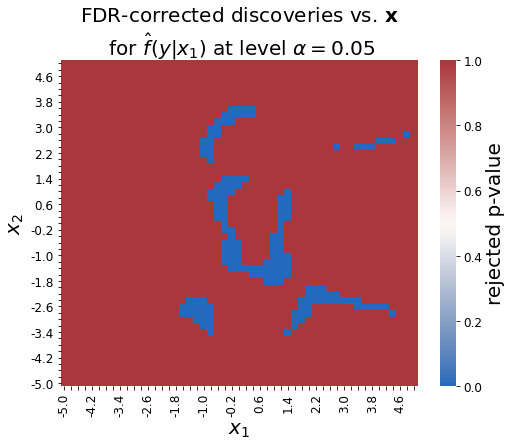

In [444]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x1.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [446]:
f_type = 'x2'
pval_vs_bh_x2 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x2.index
pval_vs_bh_x2_sorted = pd.Series(pval_vs_bh_x2.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x2_sorted == 1].index[-1]
bh_rejections_x2 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

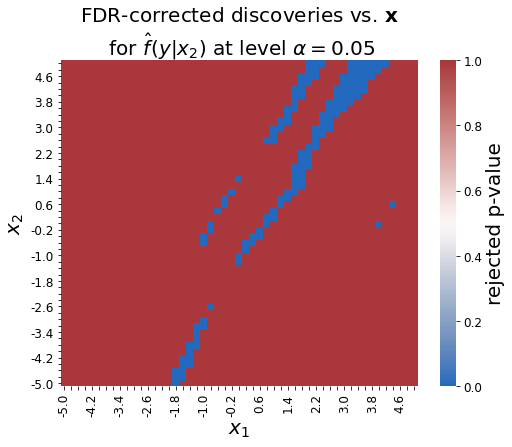

In [447]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x2.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [449]:
f_type = 'marg'
pval_vs_bh_marg = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_marg.index
pval_vs_bh_marg_sorted = pd.Series(pval_vs_bh_marg.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_marg_sorted[pval_vs_bh_marg_sorted == 1].index[-1]
bh_rejections_marg = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                               index=use_idx)

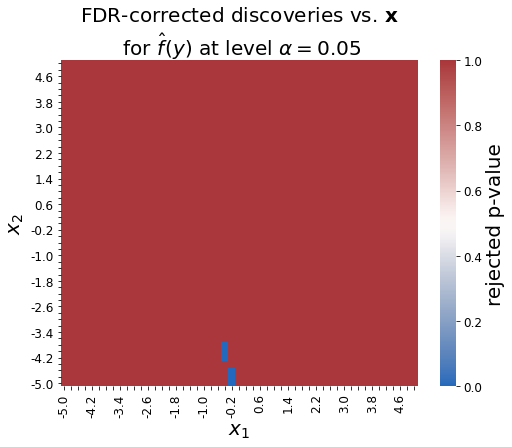

In [450]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_marg.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)